# Grab AI for S.E.A.
<br>
This repo is the submission for Grab AI for S.E.A. - Traffic Management challenge. 

1. [Problem Statement](#ps)
2. [Solution Approach](#sa)
3. [Hypotheses](#h)
4. [Features](#f)
5. [Target](#t)
6. [Model Algorithm](#ma)
7. [Train-Test-Split](#tts)
8. [Model Evaluation](#me)
9. [For Moderator](#fm)
10. [Credits](#c)

---
## <a name="ps">Problem Statement</a>
### Traffic Management
Economies in Southeast Asia are turning to AI to solve traffic congestion, which hinders mobility and economic growth. The first step in the push towards alleviating traffic congestion is to understand travel demand and travel patterns within the city.

Can we accurately forecast travel demand based on historical Grab bookings to predict areas and times with high travel demand?


## <a name="sa">Solution Approach</a>
Participants are given 2 months (61 days) of data in 15-minute intervals (buckets) and are required to forecast ahead for T+1 to T+5 given all data up to time T. There are 1,329 geographic location (in geohash6) to forecast. This is a multi-step time seris forecasting problem. A common approach is to train a model for each location. There are "missing data points" or gaps in the time series and we are required to treat them as zero aggregated demand. While it is possible to create a model for each location using ARIMA, it will consume a lot of time and resources to train over one thousand models for this challenge. Therefore, my approach is to train a single model to predict for multiple locations at the same time. This way, the model will have access to more data and able to learn the subtle patterns that repeat across locations. In effect, I am approaching the problem as a multivariate multi-step time series forecasting framed as a traditional supervised ML problem so that I can use traditional ML algorithms to solve it. 

## <a name="h">Hypotheses</a>
By creating a single model for all locations, I am hypothesizing that there are certain features that will influence the travel demand across locations. For example, the time of the day (demand will rise during rush hours), and the clusters based on proximity (locations with close proximity to each other will have similar demand).

## <a name="f">Features</a>
The "day" and "timestamp" given can be used to create "day", "hour", "minute" features. Clustering using k-means on the latitude and longitude decoded from geohash6 can be used to create clusters of location with close proximity. Lastly, as time-series problem, the lagged time series will be created as features for the model to learn about past information by bringing them forward to the present.

## <a name="t">Target</a>
However, it should be pointed out that traditional ML models can only predict one value but in this challenge we are required to forecast 5 values. To do so, we will have to use 5 data points from the past. For example, we can train a model to predict 5 steps in the future. This means that given a time series of data up to T,  the data point in T can be used to forecast T+5. In order to forecast T+1, T+2, T+3 and T+4 we will use the data points on T-4, T-3, T-2 and T-1. In effect, we are using T-4, T-3, T-2, T-1 and T to forecast ahead for T+1, T+2, T+3, T+4 and T+5, respectively.

### <a name="ma">Model Algorithm</a>
The model will be trained using [LightGBM](https://lightgbm.readthedocs.io/en/latest/). It works well on large dataset and is faster to train than XGBoost. It can work with integer-encoded categorical features without the need for one-hot encoding. It is also able to generate prediction intervals for the forecast (by means of quantile regression). Ideally, we can also train more  models using XGBoost and RandomForest and then average the results (ensemble modeling), but maybe for next iteration.


## <a name="tts">Train-Test-Split</a>
There are 61 days or 5856 buckets (after resampled), I will split 47 days (4512 buckets) as Training set and 14 days (1344 buckets) as Validation set, or roughly 77:23 ratio. Ideally, we should have a backtesting strategy using sliding window approach and the expanding window approach to test the model as suggested by [Uber](https://eng.uber.com/forecasting-introduction/), but maybe in the next iteration. 

## <a name="me">Model Evaluation</a>
As mentioned in the challenge, submissions will be evaluated by RMSE (root mean squared error) averaged over all geohash6, 15-minute-bucket pairs. I will use both MAE and RMSE to evaluate the model on the validation set.


## <a name="fm">For Moderator</a>
- I have tried my best to write comment for every cell to explain what each cell does, my apology for frequent "# take a look" comments
- Cells which require longer time to run (on my laptop) will have timer (%%time)
- I am not sure about the hold-out test dataset details, my apology for not providing step-by-step guide for making prediction on the test set, but in general:
 - pre-process the test data into time series
 - create features from datetime ("day", "dow", "hour", "minute")
 - create features for lagged series (5 periods)
 - use the same geo_cluster labels since the set of geohashes are the same in training dataset and test dataset
 - make sure the shape of test set is (x, 12)
 - load the pre-trained model ("lgb.pkl")
 - make predictions
 - evaluate results

## <a name="c">Credits</a>
- Since the challenge was announced, there has been several starter-kits made available online to help participants to overcome the cold-start problem. Particularly, I have benefited from the How-to guide from [Husein Zolkepli](https://github.com/huseinzol05/Machine-Learning-Data-Science-Reuse/tree/master/grab-aiforsea/traffic-management) and the Kaggle kernel of [Mahadir Ahmad](https://www.kaggle.com/mahadir/grab-traffic-demand-forecasting) especially on decoding geohash6 that I would like to record my appreciation here. Thank you.
---

In [1]:
# import packages
import pandas as pd
import numpy as np
import datetime as dt

# to plot within notebook
import matplotlib.pyplot as plt
%matplotlib inline

# encode geoahsh6 into integer
from sklearn.preprocessing import LabelEncoder

# to scale the data
from sklearn.preprocessing import StandardScaler

# for clustering the geohash6
from sklearn.cluster import MiniBatchKMeans

# to calculate error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

# to train the model
import lightgbm as lgb

# to save model
from sklearn.externals import joblib

# to decode geohash6 into latitude and longitude
import Geohash

# to visualize the locations
import folium

# personal preference
pd.set_option("display.expand_frame_repr", False)

In [2]:
# load the data
df = pd.read_csv("Traffic Management/training.csv")

In [3]:
# take a look at first 5 rows
df.head()

,geohash6,day,timestamp,demand
0,qp03wc,18,20:0,0.020072
1,qp03pn,10,14:30,0.024721
2,qp09sw,9,6:15,0.102821
3,qp0991,32,5:0,0.088755
4,qp090q,15,4:0,0.074468


In [4]:
# check column info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4206321 entries, 0 to 4206320
Data columns (total 4 columns):
geohash6     object
day          int64
timestamp    object
demand       float64
dtypes: float64(1), int64(1), object(2)
memory usage: 128.4+ MB


In [5]:
# check missing values
df.isnull().sum()

geohash6     0
day          0
timestamp    0
demand       0
dtype: int64

In [6]:
# check how many days of data
print("There are {} days".format(len(df["day"].unique())))
np.sort(df["day"].unique())

There are 61 days


array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61], dtype=int64)

In [7]:
# check number of unique timestamp
print("There are {} timestamp".format(len(df["timestamp"].unique())))
np.sort(df["timestamp"].unique())

There are 96 timestamp


array(['0:0', '0:15', '0:30', '0:45', '10:0', '10:15', '10:30', '10:45',
       '11:0', '11:15', '11:30', '11:45', '12:0', '12:15', '12:30',
       '12:45', '13:0', '13:15', '13:30', '13:45', '14:0', '14:15',
       '14:30', '14:45', '15:0', '15:15', '15:30', '15:45', '16:0',
       '16:15', '16:30', '16:45', '17:0', '17:15', '17:30', '17:45',
       '18:0', '18:15', '18:30', '18:45', '19:0', '19:15', '19:30',
       '19:45', '1:0', '1:15', '1:30', '1:45', '20:0', '20:15', '20:30',
       '20:45', '21:0', '21:15', '21:30', '21:45', '22:0', '22:15',
       '22:30', '22:45', '23:0', '23:15', '23:30', '23:45', '2:0', '2:15',
       '2:30', '2:45', '3:0', '3:15', '3:30', '3:45', '4:0', '4:15',
       '4:30', '4:45', '5:0', '5:15', '5:30', '5:45', '6:0', '6:15',
       '6:30', '6:45', '7:0', '7:15', '7:30', '7:45', '8:0', '8:15',
       '8:30', '8:45', '9:0', '9:15', '9:30', '9:45'], dtype=object)

In [8]:
# check number of locations i.e. geohash6
print("There are {} geohash6".format(len(df["geohash6"].unique())))
np.sort(df["geohash6"].unique())

There are 1329 geohash6


array(['qp02yc', 'qp02yf', 'qp02yu', ..., 'qp0dnh', 'qp0dnj', 'qp0dnn'],
      dtype=object)

# Decoding geohash6
With reference to sample codes for decoding from [Mahadir Ahmad.](https://www.kaggle.com/mahadir/grab-traffic-demand-forecasting)

In [9]:
# get the unique hashes
geohashes_df = df.groupby("geohash6", as_index=False)\
.agg({"day":"count"})\
.rename(columns={"day":"count"})\
.sort_values(by="count", ascending=False)

In [10]:
print("Total encoded hash", len(geohashes_df))

Total encoded hash 1329


In [11]:
# sort by descending count
geohashes_df.sort_values(by="count", ascending=False).head()

,geohash6,count
232,qp03wz,5846
275,qp03yb,5846
261,qp03xw,5846
215,qp03wf,5846
210,qp03w9,5845


In [12]:
# sort by ascending count
geohashes_df.sort_values(by="count", ascending=True).head()

,geohash6,count
1233,qp0d4m,1
1009,qp09mv,1
284,qp03yn,1
1222,qp0d45,1
409,qp08fs,1


**Note:** There should be 61x24x4 = 5856 data points or buckets of 15-min for the whole 61 days, however, none of the locations have the complete data.

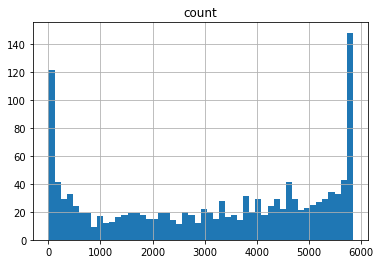

In [13]:
# distogram to show distribution of data points
geohashes_df.hist(bins=50)
plt.show()

**Note:** Very unevent distribution.

In [14]:
%%time
# decode geohash into lat and long
geohashes_df["lat"] = None
geohashes_df["lat_err"] = None
geohashes_df["long"] = None
geohashes_df["long_err"] = None
for i in range(len(geohashes_df)):
    geo_decoded = Geohash.decode_exactly(geohashes_df.loc[i,"geohash6"])
    geohashes_df.loc[i,"lat"] = geo_decoded[0]
    geohashes_df.loc[i,"long"] = geo_decoded[1]
    geohashes_df.loc[i,"lat_err"] = geo_decoded[2]
    geohashes_df.loc[i,"long_err"] = geo_decoded[3]

Wall time: 2.8 s


In [15]:
# take a look at the result
geohashes_df.head(10)

,geohash6,count,lat,lat_err,long,long_err
232,qp03wz,5846,-5.32013,0.00274658,90.6537,0.00549316
261,qp03xw,5846,-5.32562,0.00274658,90.6866,0.00549316
215,qp03wf,5846,-5.3476,0.00274658,90.6537,0.00549316
275,qp03yb,5846,-5.31464,0.00274658,90.6537,0.00549316
507,qp092m,5845,-5.37506,0.00274658,90.7196,0.00549316
683,qp0987,5845,-5.3421,0.00274658,90.7196,0.00549316
322,qp03zv,5845,-5.28717,0.00274658,90.6976,0.00549316
262,qp03xx,5845,-5.32013,0.00274658,90.6866,0.00549316
822,qp09e5,5845,-5.3421,0.00274658,90.8405,0.00549316
210,qp03w9,5845,-5.35309,0.00274658,90.6427,0.00549316


In [16]:
# convert lat and long into float type
geohashes_df["lat"] = geohashes_df["lat"].astype("float64")
geohashes_df["long"] = geohashes_df["long"].astype("float64")
geohashes_df["lat_err"] = geohashes_df["lat_err"].astype("float64")
geohashes_df["long_err"] = geohashes_df["long_err"].astype("float64")

In [17]:
# check column info to make sure data types are correct
geohashes_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1329 entries, 232 to 1233
Data columns (total 6 columns):
geohash6    1329 non-null object
count       1329 non-null int64
lat         1329 non-null float64
lat_err     1329 non-null float64
long        1329 non-null float64
long_err    1329 non-null float64
dtypes: float64(4), int64(1), object(1)
memory usage: 112.7+ KB


In [18]:
# calculate locations center point to show the map
map_center = [geohashes_df["lat"].median(), geohashes_df["long"].median()]
map_center

[-5.35308837890625, 90.7855224609375]

In [19]:
# plot the lat and long into a map

grab_map = folium.Map(location=map_center, zoom_start=5, prefer_canvas=True)

for index, row in geohashes_df.iterrows():

    folium.CircleMarker(location=(row["lat"],
                                  row["long"]),
                                  color="green",
                                  fill=True).add_to(grab_map)

grab_map

**Note:** The coordinates got mapped into Indian Ocean...<br>
**Update:** Grab said the geohash dataset is anonymised but the adjacency is maintained between the geohashes

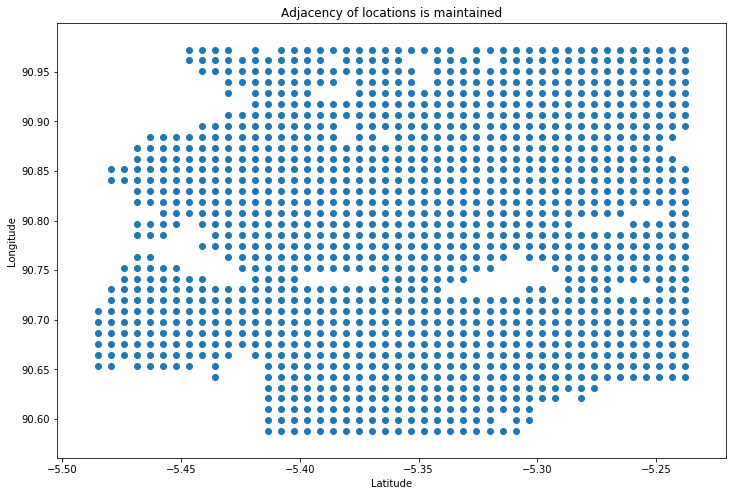

In [21]:
# alternative way of plotting coordinates

fig, ax = plt.subplots(figsize=(12,8))
# plt.scatter(geohashes_df["lat"], geohashes_df["long"], c=geohashes_df["median_demand"], cmap="rainbow")
plt.scatter(geohashes_df["lat"], geohashes_df["long"])
# plt.colorbar()
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.title("Adjacency of locations is maintained")
plt.show()

# Clustering of Locations as a Feature

In [22]:
# scale the lat and long data for clustering
X_latlong = geohashes_df[["lat", "long"]].values
X_latlong = np.nan_to_num(X_latlong)
cluster_latlong = StandardScaler().fit_transform(X_latlong)

print(cluster_latlong.shape)
cluster_latlong

(1329, 2)


array([[ 0.46490848, -1.24000708],
       [ 0.38139086, -0.93281755],
       [ 0.04732037, -1.24000708],
       ...,
       [ 0.63194372,  1.52469865],
       [-1.03840872, -0.3184385 ],
       [ 1.63415519,  0.19354404]])

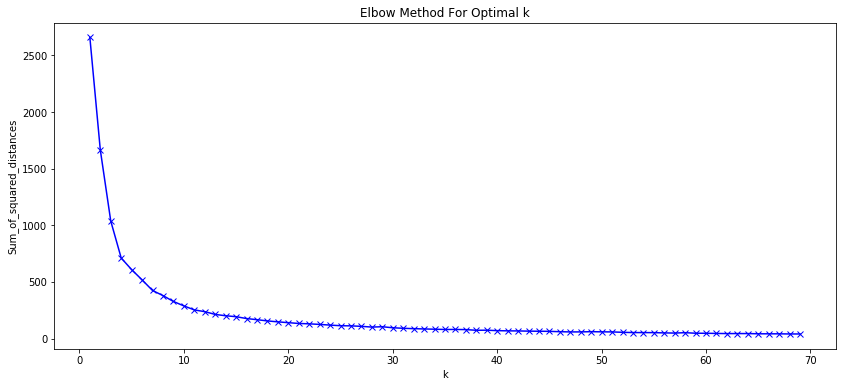

Wall time: 5.5 s


In [24]:
%%time

# find optimal k using elbow method
Sum_of_squared_distances = []
K = range(1,70)
for k in K:
    km = MiniBatchKMeans(n_clusters=k, random_state=0, batch_size=100)
    km = km.fit(cluster_latlong)
    Sum_of_squared_distances.append(km.inertia_)

plt.figure(figsize=(14,6))
plt.plot(K, Sum_of_squared_distances, "bx-")
plt.xlabel("k")
plt.ylabel("Sum_of_squared_distances")
plt.title("Elbow Method For Optimal k")
plt.show()

**Note:** We will select k=50 to cluster the locations

In [25]:
%%time
# find the cluster labels
kmeans = MiniBatchKMeans(n_clusters=50, batch_size=100).fit(cluster_latlong)
labels = kmeans.labels_

Wall time: 169 ms


In [26]:
print(len(np.unique(labels)))
np.unique(labels)

50


array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])

In [27]:
# assign the labels to the location
geohashes_df["geo_cluster"] = labels

In [28]:
# take a look
geohashes_df.head(10)

,geohash6,count,lat,lat_err,long,long_err,geo_cluster
232,qp03wz,5846,-5.320129,0.002747,90.653687,0.005493,7
261,qp03xw,5846,-5.325623,0.002747,90.686646,0.005493,15
215,qp03wf,5846,-5.347595,0.002747,90.653687,0.005493,40
275,qp03yb,5846,-5.314636,0.002747,90.653687,0.005493,7
507,qp092m,5845,-5.375061,0.002747,90.719604,0.005493,46
683,qp0987,5845,-5.342102,0.002747,90.719604,0.005493,31
322,qp03zv,5845,-5.287170,0.002747,90.697632,0.005493,22
262,qp03xx,5845,-5.320129,0.002747,90.686646,0.005493,15
822,qp09e5,5845,-5.342102,0.002747,90.840454,0.005493,39
210,qp03w9,5845,-5.353088,0.002747,90.642700,0.005493,40


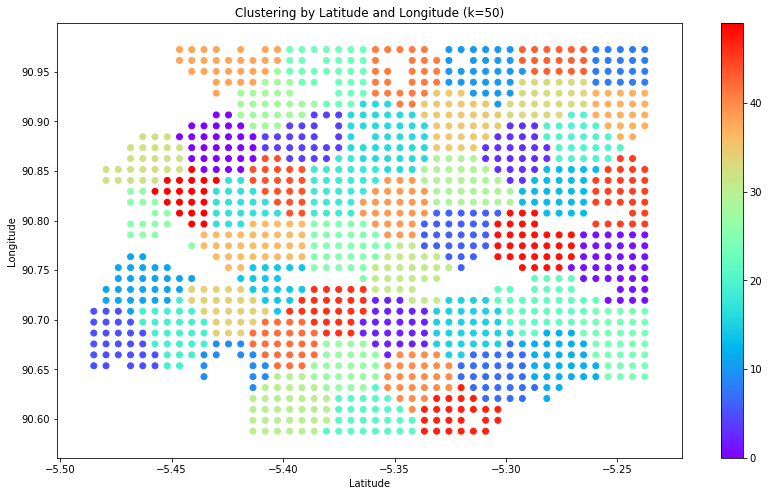

In [29]:
# plot it to visualize the cluster labels
fig, ax = plt.subplots(figsize=(14,8))
plt.scatter(geohashes_df["lat"], geohashes_df["long"], c=geohashes_df["geo_cluster"], cmap="rainbow")
plt.colorbar()
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.title("Clustering by Latitude and Longitude (k=50)")
plt.show()

In [39]:
# merge the cluster labels into original df
# df = df.merge(geohashes_df.drop(columns=["count", "lat", "lat_err", "long", "long_err"]), on="geohash6", how="inner")

In [43]:
# take a look
df.head(10)

,geohash6,day,timestamp,demand,geo_cluster
0,qp03wc,18,20:0,0.020072,0
1,qp03wc,19,5:30,0.512506,0
2,qp03wc,20,12:15,0.668930,0
3,qp03wc,59,21:0,0.047361,0
4,qp03wc,60,10:45,1.000000,0
5,qp03wc,41,6:45,0.302116,0
6,qp03wc,9,11:0,0.723699,0
7,qp03wc,26,13:30,0.459609,0
8,qp03wc,2,14:30,0.269389,0
9,qp03wc,39,2:0,0.192653,0


In [45]:
# take a look
df.tail(10)

,geohash6,day,timestamp,demand,geo_cluster
4206311,qp0919,21,9:30,0.004962,23
4206312,qp0919,13,6:15,0.002159,23
4206313,qp091j,53,7:0,0.005496,23
4206314,qp09s5,25,12:15,0.000045,27
4206315,qp09s5,38,12:45,0.006384,27
4206316,qp092b,61,8:45,0.006494,5
4206317,qp0d4m,42,12:15,0.001808,2
4206318,qp03yn,49,0:30,0.002199,24
4206319,qp09v9,45,14:15,0.002220,12
4206320,qp0d45,47,8:30,0.003062,2


# Time as Features

In [30]:
%%time
# convert timestamp from string to time
df["timestamp"] = [dt.datetime.strptime(x, "%H:%M").time() for x in df["timestamp"]]

Wall time: 41.4 s


In [31]:
%%time
# extract hour and minute from timestamp column
# df[["hour","minute"]] = df["timestamp"].str.split(":",expand=True)
# df["hour"] = df["hour"].astype("int64")
# df["minute"] = df["minute"].astype("int64")

# extract hour and minute from timestamp as features
df["hour"] =  df["timestamp"].apply(lambda x: x.hour)
df["minute"] =  df["timestamp"].apply(lambda x: x.minute)

# create "Day of Week" as a feature
df["dow"] = df["day"] % 7
# df["dom"] = df["day"].apply(lambda x : x if x <= 31 else x-31 )

# extract day of week (DoW) from day
# df["dom"] = df["day"] % 32
# df["dom"] = df["day"].apply(lambda x : x if x <= 31 else x-31 )

Wall time: 3.36 s


In [32]:
# take a look
df.head(10)

,geohash6,day,timestamp,demand,hour,minute,dow
0,qp03wc,18,20:00:00,0.020072,20,0,4
1,qp03pn,10,14:30:00,0.024721,14,30,3
2,qp09sw,9,06:15:00,0.102821,6,15,2
3,qp0991,32,05:00:00,0.088755,5,0,4
4,qp090q,15,04:00:00,0.074468,4,0,1
5,qp03tu,1,12:15:00,0.023843,12,15,1
6,qp096d,25,03:30:00,0.007460,3,30,4
7,qp03nr,51,20:45:00,0.000293,20,45,2
8,qp093r,48,06:15:00,0.054170,6,15,6
9,qp03r2,4,22:15:00,0.123463,22,15,4


In [33]:
# check column info to make sure the data types are correct
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4206321 entries, 0 to 4206320
Data columns (total 7 columns):
geohash6     object
day          int64
timestamp    object
demand       float64
hour         int64
minute       int64
dow          int64
dtypes: float64(1), int64(4), object(2)
memory usage: 224.6+ MB


# Process Data into Time Series
We will define a function to convert day,hour,minute into datetimestamp to create a time series. This also allows us to resample the data to fill in the gaps in the time series. In real life, the datetimestamp is probably given, so this step is not necesssary. The starter-kit from [Mahadir Ahmad](https://www.kaggle.com/mahadir/grab-traffic-demand-forecasting) suggested the two months to be October and November, so we will start our time series from October.

In [34]:
# define a function

def convert_datetimestamp(x):
    if x["day"] <= 31:
        datetimestamp = dt.datetime(2018, 10, x["day"], x["hour"], x["minute"])
    if (x["day"] > 31) & (x["day"] <= 61):
        datetimestamp = dt.datetime(2018, 11, x["day"]-31, x["hour"], x["minute"])
    if (x["day"] > 61) & (x["day"] <= 92):
        datetimestamp = dt.datetime(2018, 12,x ["day"]-61, x["hour"], x["minute"])
    if (x["day"] > 92) & (x["day"] <= 123):
        datetimestamp = dt.datetime(2019, 1, x["day"]-92, x["hour"], x["minute"])
    return datetimestamp

In [35]:
%%time
# apply the function
df["datetimestamp"] = df[["day", "hour", "minute"]].apply(convert_datetimestamp, axis=1)

Wall time: 5min 27s


In [36]:
# sort the data
df = df.sort_values(by=["datetimestamp", "geohash6"])

In [37]:
# take a look
df.head(10)

,geohash6,day,timestamp,demand,hour,minute,dow,datetimestamp
346165,qp02zd,1,00:00:00,0.022396,0,0,1,2018-10-01
2147990,qp02zr,1,00:00:00,0.042046,0,0,1,2018-10-01
1406859,qp02zt,1,00:00:00,0.001112,0,0,1,2018-10-01
3516339,qp02zu,1,00:00:00,0.001831,0,0,1,2018-10-01
3570224,qp02zv,1,00:00:00,0.006886,0,0,1,2018-10-01
4078670,qp02zw,1,00:00:00,0.027161,0,0,1,2018-10-01
3447652,qp02zx,1,00:00:00,0.043180,0,0,1,2018-10-01
2697025,qp02zz,1,00:00:00,0.176994,0,0,1,2018-10-01
2812569,qp03jq,1,00:00:00,0.009146,0,0,1,2018-10-01
3650736,qp03jr,1,00:00:00,0.019114,0,0,1,2018-10-01


In [38]:
# take a look
df.tail(10)

,geohash6,day,timestamp,demand,hour,minute,dow,datetimestamp
1516208,qp0dhh,61,23:45:00,0.001558,23,45,5,2018-11-30 23:45:00
320280,qp0dhk,61,23:45:00,0.004045,23,45,5,2018-11-30 23:45:00
1140729,qp0dht,61,23:45:00,0.028584,23,45,5,2018-11-30 23:45:00
1174567,qp0dhw,61,23:45:00,0.033687,23,45,5,2018-11-30 23:45:00
2887890,qp0dj0,61,23:45:00,0.019824,23,45,5,2018-11-30 23:45:00
3359762,qp0dj1,61,23:45:00,0.040727,23,45,5,2018-11-30 23:45:00
2252729,qp0dj4,61,23:45:00,0.003259,23,45,5,2018-11-30 23:45:00
4035420,qp0dj5,61,23:45:00,0.058156,23,45,5,2018-11-30 23:45:00
3201270,qp0djh,61,23:45:00,0.011935,23,45,5,2018-11-30 23:45:00
1896104,qp0djk,61,23:45:00,0.003414,23,45,5,2018-11-30 23:45:00


In [39]:
# check column info to make sure the data types are correct
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4206321 entries, 346165 to 1896104
Data columns (total 8 columns):
geohash6         object
day              int64
timestamp        object
demand           float64
hour             int64
minute           int64
dow              int64
datetimestamp    datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(4), object(2)
memory usage: 288.8+ MB


In [40]:
# make a copy in case we need to use it again
df1 = df.copy()

In [41]:
# set datetimestamp as index 
df1 = df1.set_index("datetimestamp")

In [42]:
# take a look
df1.head(10)

,geohash6,day,timestamp,demand,hour,minute,dow
datetimestamp,,,,,,,
2018-10-01,qp02zd,1,00:00:00,0.022396,0,0,1
2018-10-01,qp02zr,1,00:00:00,0.042046,0,0,1
2018-10-01,qp02zt,1,00:00:00,0.001112,0,0,1
2018-10-01,qp02zu,1,00:00:00,0.001831,0,0,1
2018-10-01,qp02zv,1,00:00:00,0.006886,0,0,1
2018-10-01,qp02zw,1,00:00:00,0.027161,0,0,1
2018-10-01,qp02zx,1,00:00:00,0.043180,0,0,1
2018-10-01,qp02zz,1,00:00:00,0.176994,0,0,1
2018-10-01,qp03jq,1,00:00:00,0.009146,0,0,1


In [43]:
%%time
# reshape the data using pivot
df2 = df1.pivot(index=df1.index, columns="geohash6")

Wall time: 8.56 s


In [44]:
# take a look
df2.head()

day                                                                 ...    dow                                                               
geohash6            qp02yc qp02yf qp02yu qp02yv qp02yy qp02yz qp02z1 qp02z3 qp02z4 qp02z5  ... qp0djv qp0djw qp0djy qp0dn0 qp0dn1 qp0dn4 qp0dn5 qp0dnh qp0dnj qp0dnn
datetimestamp                                                                              ...                                                                      
2018-10-01 00:00:00    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN
2018-10-01 00:15:00    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    1.0  ...    NaN    NaN    1.0    NaN    NaN    NaN    NaN    NaN    NaN    NaN
2018-10-01 00:30:00    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    1.0    NaN
2018-10-01 00:45:00    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN
2018-10-01 01:00:00    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN  ...    NaN    NaN    1.0    NaN    NaN    NaN    NaN    NaN    1.0    NaN

[5 rows x 7974 columns]

In [45]:
%%time
# resample the data into 15-minute bucket to fill the gap of missing time values
df3 = df2.resample("15T").asfreq()

Wall time: 1.04 s


In [46]:
# take a look
df3.head()

day                                                                 ...    dow                                                               
geohash6            qp02yc qp02yf qp02yu qp02yv qp02yy qp02yz qp02z1 qp02z3 qp02z4 qp02z5  ... qp0djv qp0djw qp0djy qp0dn0 qp0dn1 qp0dn4 qp0dn5 qp0dnh qp0dnj qp0dnn
datetimestamp                                                                              ...                                                                      
2018-10-01 00:00:00    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN
2018-10-01 00:15:00    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    1.0  ...    NaN    NaN    1.0    NaN    NaN    NaN    NaN    NaN    NaN    NaN
2018-10-01 00:30:00    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    1.0    NaN
2018-10-01 00:45:00    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN
2018-10-01 01:00:00    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN  ...    NaN    NaN    1.0    NaN    NaN    NaN    NaN    NaN    1.0    NaN

[5 rows x 7974 columns]

In [47]:
# create a bucket column and append it to the current index
df3["bucket"] = np.arange(1, len(df3)+1)
df3.set_index("bucket", append=True, inplace=True)

In [48]:
# take a look
df3.head()

day                                                                 ...    dow                                                               
geohash6                   qp02yc qp02yf qp02yu qp02yv qp02yy qp02yz qp02z1 qp02z3 qp02z4 qp02z5  ... qp0djv qp0djw qp0djy qp0dn0 qp0dn1 qp0dn4 qp0dn5 qp0dnh qp0dnj qp0dnn
datetimestamp       bucket                                                                        ...                                                                      
2018-10-01 00:00:00 1         NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN
2018-10-01 00:15:00 2         NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    1.0  ...    NaN    NaN    1.0    NaN    NaN    NaN    NaN    NaN    NaN    NaN
2018-10-01 00:30:00 3         NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    1.0    NaN
2018-10-01 00:45:00 4         NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN
2018-10-01 01:00:00 5         NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN  ...    NaN    NaN    1.0    NaN    NaN    NaN    NaN    NaN    1.0    NaN

[5 rows x 7974 columns]

In [49]:
# take a look
df3.tail()

day                                                                 ...    dow                                                               
geohash6                   qp02yc qp02yf qp02yu qp02yv qp02yy qp02yz qp02z1 qp02z3 qp02z4 qp02z5  ... qp0djv qp0djw qp0djy qp0dn0 qp0dn1 qp0dn4 qp0dn5 qp0dnh qp0dnj qp0dnn
datetimestamp       bucket                                                                        ...                                                                      
2018-11-30 22:45:00 5852      NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    5.0    NaN
2018-11-30 23:00:00 5853      NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN
2018-11-30 23:15:00 5854      NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN
2018-11-30 23:30:00 5855      NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN
2018-11-30 23:45:00 5856      NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN

[5 rows x 7974 columns]

In [50]:
# check the number is tally
print("We need to have {} buckets = 61 days x 24 hours x 4 buckets of 15-min intervals".format(61*24*4))
print("The data has {} buckets".format(len(df3)))
len(df3)==61*24*4

We need to have 5856 buckets = 61 days x 24 hours x 4 buckets of 15-min intervals
The data has 5856 buckets


True

In [51]:
%%time
# reshape the data by stacking it back
df4 = df3.stack(dropna=False)

Wall time: 2.71 s


In [52]:
# take a look
df4.head(10)

day  demand  dow  hour  minute timestamp
datetimestamp bucket geohash6                                          
2018-10-01    1      qp02yc    NaN     NaN  NaN   NaN     NaN       NaN
                     qp02yf    NaN     NaN  NaN   NaN     NaN       NaN
                     qp02yu    NaN     NaN  NaN   NaN     NaN       NaN
                     qp02yv    NaN     NaN  NaN   NaN     NaN       NaN
                     qp02yy    NaN     NaN  NaN   NaN     NaN       NaN
                     qp02yz    NaN     NaN  NaN   NaN     NaN       NaN
                     qp02z1    NaN     NaN  NaN   NaN     NaN       NaN
                     qp02z3    NaN     NaN  NaN   NaN     NaN       NaN
                     qp02z4    NaN     NaN  NaN   NaN     NaN       NaN
                     qp02z5    NaN     NaN  NaN   NaN     NaN       NaN

In [53]:
# take a look
df4.tail(10)

day  demand  dow  hour  minute timestamp
datetimestamp       bucket geohash6                                          
2018-11-30 23:45:00 5856   qp0djv    NaN     NaN  NaN   NaN     NaN       NaN
                           qp0djw    NaN     NaN  NaN   NaN     NaN       NaN
                           qp0djy    NaN     NaN  NaN   NaN     NaN       NaN
                           qp0dn0    NaN     NaN  NaN   NaN     NaN       NaN
                           qp0dn1    NaN     NaN  NaN   NaN     NaN       NaN
                           qp0dn4    NaN     NaN  NaN   NaN     NaN       NaN
                           qp0dn5    NaN     NaN  NaN   NaN     NaN       NaN
                           qp0dnh    NaN     NaN  NaN   NaN     NaN       NaN
                           qp0dnj    NaN     NaN  NaN   NaN     NaN       NaN
                           qp0dnn    NaN     NaN  NaN   NaN     NaN       NaN

In [54]:
%%time
# reset index and sort the data
df5 = df4.reset_index().sort_values(by=["datetimestamp", "geohash6"])

Wall time: 4.67 s


In [55]:
# take a look
df5.head(10)

,datetimestamp,bucket,geohash6,day,demand,dow,hour,minute,timestamp
0,2018-10-01,1,qp02yc,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-10-01,1,qp02yf,NaN,NaN,NaN,NaN,NaN,NaN
2,2018-10-01,1,qp02yu,NaN,NaN,NaN,NaN,NaN,NaN
3,2018-10-01,1,qp02yv,NaN,NaN,NaN,NaN,NaN,NaN
4,2018-10-01,1,qp02yy,NaN,NaN,NaN,NaN,NaN,NaN
5,2018-10-01,1,qp02yz,NaN,NaN,NaN,NaN,NaN,NaN
6,2018-10-01,1,qp02z1,NaN,NaN,NaN,NaN,NaN,NaN
7,2018-10-01,1,qp02z3,NaN,NaN,NaN,NaN,NaN,NaN
8,2018-10-01,1,qp02z4,NaN,NaN,NaN,NaN,NaN,NaN
9,2018-10-01,1,qp02z5,NaN,NaN,NaN,NaN,NaN,NaN


In [56]:
# take a look
df5.tail(10)

,datetimestamp,bucket,geohash6,day,demand,dow,hour,minute,timestamp
7782614,2018-11-30 23:45:00,5856,qp0djv,NaN,NaN,NaN,NaN,NaN,NaN
7782615,2018-11-30 23:45:00,5856,qp0djw,NaN,NaN,NaN,NaN,NaN,NaN
7782616,2018-11-30 23:45:00,5856,qp0djy,NaN,NaN,NaN,NaN,NaN,NaN
7782617,2018-11-30 23:45:00,5856,qp0dn0,NaN,NaN,NaN,NaN,NaN,NaN
7782618,2018-11-30 23:45:00,5856,qp0dn1,NaN,NaN,NaN,NaN,NaN,NaN
7782619,2018-11-30 23:45:00,5856,qp0dn4,NaN,NaN,NaN,NaN,NaN,NaN
7782620,2018-11-30 23:45:00,5856,qp0dn5,NaN,NaN,NaN,NaN,NaN,NaN
7782621,2018-11-30 23:45:00,5856,qp0dnh,NaN,NaN,NaN,NaN,NaN,NaN
7782622,2018-11-30 23:45:00,5856,qp0dnj,NaN,NaN,NaN,NaN,NaN,NaN
7782623,2018-11-30 23:45:00,5856,qp0dnn,NaN,NaN,NaN,NaN,NaN,NaN


In [57]:
# check the number is tally
print("We need to have total {} buckets = 1329 geohash6 x 61 days x 24 hours x 4 buckets of 15-min intervals".format(1329*61*24*4))
print("The data has {} buckets".format(len(df5)))
len(df5)==1329*61*24*4

We need to have total 7782624 buckets = 1329 geohash6 x 61 days x 24 hours x 4 buckets of 15-min intervals
The data has 7782624 buckets


True

In [58]:
# check column info to make sure the data types are correct
df5.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7782624 entries, 0 to 7782623
Data columns (total 9 columns):
datetimestamp    datetime64[ns]
bucket           int64
geohash6         object
day              float64
demand           float64
dow              float64
hour             float64
minute           float64
timestamp        object
dtypes: datetime64[ns](1), float64(5), int64(1), object(2)
memory usage: 593.8+ MB


In [59]:
%%time
# fill in missing values for the "gaps" in the time series
df5["hour"] =  df5["datetimestamp"].dt.hour
df5["minute"] =  df5["datetimestamp"].dt.minute

Wall time: 1.45 s


In [60]:
# define a function to find the day from the year and month
def find_day(x):
    if (x.year == 2018) & (x.month == 10):
        day = x.day
    if (x.year == 2018) & (x.month == 11):
        day = x.day + 31
    if (x.year == 2018) & (x.month == 12):
        day = x.day + 61
    if (x.year == 2019) & (x.month == 1):
        day = x.day + 92    
    return day

In [61]:
%%time
# fill in missing values for the "gaps" in the time series
df5["day"] = df5["datetimestamp"].apply(find_day)

# for day of week
df5["dow"] = df5["day"] % 7

Wall time: 24.9 s


In [62]:
# sort the data
df5 = df5.sort_values(["datetimestamp", "geohash6"])

In [63]:
# take a look
df5.head()

,datetimestamp,bucket,geohash6,day,demand,dow,hour,minute,timestamp
0,2018-10-01,1,qp02yc,1,NaN,1,0,0,NaN
1,2018-10-01,1,qp02yf,1,NaN,1,0,0,NaN
2,2018-10-01,1,qp02yu,1,NaN,1,0,0,NaN
3,2018-10-01,1,qp02yv,1,NaN,1,0,0,NaN
4,2018-10-01,1,qp02yy,1,NaN,1,0,0,NaN


In [64]:
# merge the cluster labels into the dataframe
df5 = df5.merge(geohashes_df.drop(columns=["count", "lat", "lat_err", "long", "long_err"]), on="geohash6", how="inner")

In [65]:
# label encode the geohash6
labelencoder = LabelEncoder()
df5["geo_encoded"] = labelencoder.fit_transform(df5["geohash6"])

In [66]:
# demand fillna with 0
df5["demand"].fillna(value=0, inplace=True)

In [67]:
# take a look
df5.head(10)

,datetimestamp,bucket,geohash6,day,demand,dow,hour,minute,timestamp,geo_cluster,geo_encoded
0,2018-10-01 00:00:00,1,qp02yc,1,0.0,1,0,0,NaN,5,0
1,2018-10-01 00:15:00,2,qp02yc,1,0.0,1,0,15,NaN,5,0
2,2018-10-01 00:30:00,3,qp02yc,1,0.0,1,0,30,NaN,5,0
3,2018-10-01 00:45:00,4,qp02yc,1,0.0,1,0,45,NaN,5,0
4,2018-10-01 01:00:00,5,qp02yc,1,0.0,1,1,0,NaN,5,0
5,2018-10-01 01:15:00,6,qp02yc,1,0.0,1,1,15,NaN,5,0
6,2018-10-01 01:30:00,7,qp02yc,1,0.0,1,1,30,NaN,5,0
7,2018-10-01 01:45:00,8,qp02yc,1,0.0,1,1,45,NaN,5,0
8,2018-10-01 02:00:00,9,qp02yc,1,0.0,1,2,0,NaN,5,0
9,2018-10-01 02:15:00,10,qp02yc,1,0.0,1,2,15,NaN,5,0


In [68]:
# check column info to make sure the data types are correct
df5.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7782624 entries, 0 to 7782623
Data columns (total 11 columns):
datetimestamp    datetime64[ns]
bucket           int64
geohash6         object
day              int64
demand           float64
dow              int64
hour             int64
minute           int64
timestamp        object
geo_cluster      int32
geo_encoded      int32
dtypes: datetime64[ns](1), float64(1), int32(2), int64(5), object(2)
memory usage: 653.1+ MB


In [69]:
# check missing values
df5.isnull().sum()

datetimestamp          0
bucket                 0
geohash6               0
day                    0
demand                 0
dow                    0
hour                   0
minute                 0
timestamp        3576303
geo_cluster            0
geo_encoded            0
dtype: int64

# Lagged Series as Features
Right now, we have day, day of week, hour, minute and geo_cluster as features. In order to forecast 5-steps ahead, we need to create lagged time series as features. We will create 5 lagged series, the more lagged series usually the better, but it will take longer time to train and prone to overfitting.

In [71]:
# make a copy in case we need to use it again
df6 = df5.copy()

In [72]:
%%time

# create features
for i in range(1,6):
    df6["demand_t-"+str(i)] = df6.groupby(["geo_encoded"])["demand"].shift(i)

#     additional feature
#     df6["demand_t-"+str(i)+"_diff"] = df6.groupby(["geo_encoded"])["demand_t-"+str(i)].diff()

Wall time: 3.05 s


In [73]:
# take a look
df6[df6["geo_encoded"]==232].iloc[:15]

,datetimestamp,bucket,geohash6,day,demand,dow,hour,minute,timestamp,geo_cluster,geo_encoded,demand_t-1,demand_t-2,demand_t-3,demand_t-4,demand_t-5
1358592,2018-10-01 00:00:00,1,qp03wz,1,0.406610,1,0,0,00:00:00,7,232,NaN,NaN,NaN,NaN,NaN
1358593,2018-10-01 00:15:00,2,qp03wz,1,0.429288,1,0,15,00:15:00,7,232,0.406610,NaN,NaN,NaN,NaN
1358594,2018-10-01 00:30:00,3,qp03wz,1,0.422702,1,0,30,00:30:00,7,232,0.429288,0.406610,NaN,NaN,NaN
1358595,2018-10-01 00:45:00,4,qp03wz,1,0.390570,1,0,45,00:45:00,7,232,0.422702,0.429288,0.406610,NaN,NaN
1358596,2018-10-01 01:00:00,5,qp03wz,1,0.399400,1,1,0,01:00:00,7,232,0.390570,0.422702,0.429288,0.406610,NaN
1358597,2018-10-01 01:15:00,6,qp03wz,1,0.357082,1,1,15,01:15:00,7,232,0.399400,0.390570,0.422702,0.429288,0.406610
1358598,2018-10-01 01:30:00,7,qp03wz,1,0.328328,1,1,30,01:30:00,7,232,0.357082,0.399400,0.390570,0.422702,0.429288
1358599,2018-10-01 01:45:00,8,qp03wz,1,0.412305,1,1,45,01:45:00,7,232,0.328328,0.357082,0.399400,0.390570,0.422702
1358600,2018-10-01 02:00:00,9,qp03wz,1,0.450503,1,2,0,02:00:00,7,232,0.412305,0.328328,0.357082,0.399400,0.390570
1358601,2018-10-01 02:15:00,10,qp03wz,1,0.429165,1,2,15,02:15:00,7,232,0.450503,0.412305,0.328328,0.357082,0.399400


# Create Target Variable
The target variable that we want to predict is demand at T+5 given demand at T, which is 5 steps ahead. We can create this by using the method `.shift(-5)`. To prevent data from validation set leaking into Training set, we need to split the data BEFORE creating the target variable. By doing so, the last 5 buckets of the Training set will have NaN as target variable values and we will drop them off before training the model.

There are 61 days or 5856 buckets, we will split 47 days (4512 buckets) as Training set and 14 days (1344 buckets) as Validation set, or roughly 77:23 ratio.

In [74]:
# split the dataset into Training and Validation sets
train_df = df6[df6["bucket"] <= 4512]
val_df = df6[df6["bucket"] > 4512]

In [75]:
# check the split is correct by dividing with the number of unique geohash6
train_df.shape[0]/1329, val_df.shape[0]/1329

(4512.0, 1344.0)

In [76]:
# make a copy in case we need to use it again
train = train_df.copy()
val = val_df.copy()

In [77]:
%%time
# create target variable
train["target"] = train.groupby(["geo_encoded"])["demand"].shift(-5)
val["target"] = val.groupby(["geo_encoded"])["demand"].shift(-5)

Wall time: 2.32 s


In [78]:
# take a look at Training set
train[train["geo_encoded"]==232].iloc[:10]

,datetimestamp,bucket,geohash6,day,demand,dow,hour,minute,timestamp,geo_cluster,geo_encoded,demand_t-1,demand_t-2,demand_t-3,demand_t-4,demand_t-5,target
1358592,2018-10-01 00:00:00,1,qp03wz,1,0.406610,1,0,0,00:00:00,7,232,NaN,NaN,NaN,NaN,NaN,0.357082
1358593,2018-10-01 00:15:00,2,qp03wz,1,0.429288,1,0,15,00:15:00,7,232,0.406610,NaN,NaN,NaN,NaN,0.328328
1358594,2018-10-01 00:30:00,3,qp03wz,1,0.422702,1,0,30,00:30:00,7,232,0.429288,0.406610,NaN,NaN,NaN,0.412305
1358595,2018-10-01 00:45:00,4,qp03wz,1,0.390570,1,0,45,00:45:00,7,232,0.422702,0.429288,0.406610,NaN,NaN,0.450503
1358596,2018-10-01 01:00:00,5,qp03wz,1,0.399400,1,1,0,01:00:00,7,232,0.390570,0.422702,0.429288,0.406610,NaN,0.429165
1358597,2018-10-01 01:15:00,6,qp03wz,1,0.357082,1,1,15,01:15:00,7,232,0.399400,0.390570,0.422702,0.429288,0.406610,0.316972
1358598,2018-10-01 01:30:00,7,qp03wz,1,0.328328,1,1,30,01:30:00,7,232,0.357082,0.399400,0.390570,0.422702,0.429288,0.338515
1358599,2018-10-01 01:45:00,8,qp03wz,1,0.412305,1,1,45,01:45:00,7,232,0.328328,0.357082,0.399400,0.390570,0.422702,0.599485
1358600,2018-10-01 02:00:00,9,qp03wz,1,0.450503,1,2,0,02:00:00,7,232,0.412305,0.328328,0.357082,0.399400,0.390570,0.682052
1358601,2018-10-01 02:15:00,10,qp03wz,1,0.429165,1,2,15,02:15:00,7,232,0.450503,0.412305,0.328328,0.357082,0.399400,0.496798


In [79]:
# take a look at Training set
train[train["geo_encoded"]==232].iloc[-10:]

,datetimestamp,bucket,geohash6,day,demand,dow,hour,minute,timestamp,geo_cluster,geo_encoded,demand_t-1,demand_t-2,demand_t-3,demand_t-4,demand_t-5,target
1363094,2018-11-16 21:30:00,4503,qp03wz,47,0.156197,5,21,30,21:30:00,7,232,0.142692,0.173483,0.175224,0.115803,0.132904,0.104459
1363095,2018-11-16 21:45:00,4504,qp03wz,47,0.114755,5,21,45,21:45:00,7,232,0.156197,0.142692,0.173483,0.175224,0.115803,0.180922
1363096,2018-11-16 22:00:00,4505,qp03wz,47,0.164028,5,22,0,22:00:00,7,232,0.114755,0.156197,0.142692,0.173483,0.175224,0.149980
1363097,2018-11-16 22:15:00,4506,qp03wz,47,0.109416,5,22,15,22:15:00,7,232,0.164028,0.114755,0.156197,0.142692,0.173483,0.144410
1363098,2018-11-16 22:30:00,4507,qp03wz,47,0.079603,5,22,30,22:30:00,7,232,0.109416,0.164028,0.114755,0.156197,0.142692,0.127522
1363099,2018-11-16 22:45:00,4508,qp03wz,47,0.104459,5,22,45,22:45:00,7,232,0.079603,0.109416,0.164028,0.114755,0.156197,NaN
1363100,2018-11-16 23:00:00,4509,qp03wz,47,0.180922,5,23,0,23:00:00,7,232,0.104459,0.079603,0.109416,0.164028,0.114755,NaN
1363101,2018-11-16 23:15:00,4510,qp03wz,47,0.149980,5,23,15,23:15:00,7,232,0.180922,0.104459,0.079603,0.109416,0.164028,NaN
1363102,2018-11-16 23:30:00,4511,qp03wz,47,0.144410,5,23,30,23:30:00,7,232,0.149980,0.180922,0.104459,0.079603,0.109416,NaN
1363103,2018-11-16 23:45:00,4512,qp03wz,47,0.127522,5,23,45,23:45:00,7,232,0.144410,0.149980,0.180922,0.104459,0.079603,NaN


In [80]:
# check for NaN
train.isnull().sum()

datetimestamp          0
bucket                 0
geohash6               0
day                    0
demand                 0
dow                    0
hour                   0
minute                 0
timestamp        2782956
geo_cluster            0
geo_encoded            0
demand_t-1          1329
demand_t-2          2658
demand_t-3          3987
demand_t-4          5316
demand_t-5          6645
target              6645
dtype: int64

**Note:** As expected, the last 5 buckets in Training set are NaN because we do not want Validation data leaking into Training set.

In [81]:
# take a look at Validation set
val[val["geo_encoded"]==232].iloc[:10]

,datetimestamp,bucket,geohash6,day,demand,dow,hour,minute,timestamp,geo_cluster,geo_encoded,demand_t-1,demand_t-2,demand_t-3,demand_t-4,demand_t-5,target
1363104,2018-11-17 00:00:00,4513,qp03wz,48,0.131465,6,0,0,00:00:00,7,232,0.127522,0.144410,0.149980,0.180922,0.104459,0.216866
1363105,2018-11-17 00:15:00,4514,qp03wz,48,0.114013,6,0,15,00:15:00,7,232,0.131465,0.127522,0.144410,0.149980,0.180922,0.177557
1363106,2018-11-17 00:30:00,4515,qp03wz,48,0.119988,6,0,30,00:30:00,7,232,0.114013,0.131465,0.127522,0.144410,0.149980,0.160022
1363107,2018-11-17 00:45:00,4516,qp03wz,48,0.119428,6,0,45,00:45:00,7,232,0.119988,0.114013,0.131465,0.127522,0.144410,0.175371
1363108,2018-11-17 01:00:00,4517,qp03wz,48,0.127833,6,1,0,01:00:00,7,232,0.119428,0.119988,0.114013,0.131465,0.127522,0.181809
1363109,2018-11-17 01:15:00,4518,qp03wz,48,0.216866,6,1,15,01:15:00,7,232,0.127833,0.119428,0.119988,0.114013,0.131465,0.177994
1363110,2018-11-17 01:30:00,4519,qp03wz,48,0.177557,6,1,30,01:30:00,7,232,0.216866,0.127833,0.119428,0.119988,0.114013,0.204619
1363111,2018-11-17 01:45:00,4520,qp03wz,48,0.160022,6,1,45,01:45:00,7,232,0.177557,0.216866,0.127833,0.119428,0.119988,0.181649
1363112,2018-11-17 02:00:00,4521,qp03wz,48,0.175371,6,2,0,02:00:00,7,232,0.160022,0.177557,0.216866,0.127833,0.119428,0.278270
1363113,2018-11-17 02:15:00,4522,qp03wz,48,0.181809,6,2,15,02:15:00,7,232,0.175371,0.160022,0.177557,0.216866,0.127833,0.353417


In [82]:
# take a look at Validation set
val[val["geo_encoded"]==232].iloc[-10:]

,datetimestamp,bucket,geohash6,day,demand,dow,hour,minute,timestamp,geo_cluster,geo_encoded,demand_t-1,demand_t-2,demand_t-3,demand_t-4,demand_t-5,target
1364438,2018-11-30 21:30:00,5847,qp03wz,61,0.112805,5,21,30,21:30:00,7,232,0.166976,0.260445,0.204161,0.215769,0.227831,0.123493
1364439,2018-11-30 21:45:00,5848,qp03wz,61,0.152825,5,21,45,21:45:00,7,232,0.112805,0.166976,0.260445,0.204161,0.215769,0.150140
1364440,2018-11-30 22:00:00,5849,qp03wz,61,0.166774,5,22,0,22:00:00,7,232,0.152825,0.112805,0.166976,0.260445,0.204161,0.145052
1364441,2018-11-30 22:15:00,5850,qp03wz,61,0.153463,5,22,15,22:15:00,7,232,0.166774,0.152825,0.112805,0.166976,0.260445,0.176834
1364442,2018-11-30 22:30:00,5851,qp03wz,61,0.117858,5,22,30,22:30:00,7,232,0.153463,0.166774,0.152825,0.112805,0.166976,0.159342
1364443,2018-11-30 22:45:00,5852,qp03wz,61,0.123493,5,22,45,22:45:00,7,232,0.117858,0.153463,0.166774,0.152825,0.112805,NaN
1364444,2018-11-30 23:00:00,5853,qp03wz,61,0.150140,5,23,0,23:00:00,7,232,0.123493,0.117858,0.153463,0.166774,0.152825,NaN
1364445,2018-11-30 23:15:00,5854,qp03wz,61,0.145052,5,23,15,23:15:00,7,232,0.150140,0.123493,0.117858,0.153463,0.166774,NaN
1364446,2018-11-30 23:30:00,5855,qp03wz,61,0.176834,5,23,30,23:30:00,7,232,0.145052,0.150140,0.123493,0.117858,0.153463,NaN
1364447,2018-11-30 23:45:00,5856,qp03wz,61,0.159342,5,23,45,23:45:00,7,232,0.176834,0.145052,0.150140,0.123493,0.117858,NaN


In [83]:
# check for NaN
val.isnull().sum()

datetimestamp         0
bucket                0
geohash6              0
day                   0
demand                0
dow                   0
hour                  0
minute                0
timestamp        793347
geo_cluster           0
geo_encoded           0
demand_t-1            0
demand_t-2            0
demand_t-3            0
demand_t-4            0
demand_t-5            0
target             6645
dtype: int64

**Note:** The last 5 buckets in Validation set is also NaN because we do not know the future data.

In [84]:
# drop NaN
train = train.dropna()
val = val.dropna()

In [85]:
# check for any NaN again
train.isnull().any().sum(), val.isnull().any().sum()

(0, 0)

In [86]:
# check data shape
train.shape, val.shape

((3207289, 17), (990189, 17))

In [87]:
# prepare data for training
X_train = train.drop(["datetimestamp", "bucket", "geohash6", "timestamp", "target"], axis=1)
y_train = train["target"].values

In [88]:
# check data shape
X_train.shape, y_train.shape

((3207289, 12), (3207289,))

In [89]:
# prepare data for prediction and evaluation
X_test = val.drop(["datetimestamp", "bucket", "geohash6", "timestamp", "target"], axis=1)
y_test = val["target"].values

In [90]:
# check data shape
X_test.shape, y_test.shape

((990189, 12), (990189,))

In [91]:
# check columns in train and val are the same
(X_train.columns == X_test.columns).sum()

12

# LightGBM

In [92]:
# load train set, specify "geo_encoded" and "geo_cluster" as categorical_feature
train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=["geo_encoded", "geo_cluster"])

# setting parameters for lightgbm
params = {}
params["learning_rate"] = 0.01
params["boosting_type"] = "gbdt"
params["objective"] = "regression"
params["metric"] = "rmse"
params["sub_feature"] = 0.5
params["num_leaves"] = 100
params["min_data"] = 1000
params["max_depth"] = 10


In [93]:
%%time

# train the model
lgb_regr = lgb.train(params, train_data, 100)

C:\Users\limchiahooi\Anaconda3\lib\site-packages\lightgbm\basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Wall time: 25.4 s


In [94]:
# make prediction
lgb_y_pred = lgb_regr.predict(X_test)

In [95]:
# check shape
lgb_y_pred.shape, y_test.shape

((990189,), (990189,))

In [96]:
# calculate MAE
lgb_mae = mean_absolute_error(y_test, lgb_y_pred)
lgb_mae

0.050332992120768374

In [97]:
# calculate RMSE
lgb_rmse = np.sqrt(mean_squared_error(y_test, lgb_y_pred))
lgb_rmse

0.0820916485385049

In [98]:
# save model
joblib.dump(lgb_regr, "lgb.pkl")

['lgb.pkl']

# Forecast for the next 5 buckets
Remember the last 5 buckets of the Validation set were dropped, now we can use the model to predict for these 5 buckets in order to forecast the next 5 buckets i.e. T+1, T+2, T+3, T+4, T+5. The last 5 buckets are bucket 5852 to 5856.

In [99]:
# make a copy of the validation set
val_pred = val_df.copy()

In [100]:
# select the last 5 buckets
val_pred_5b = val_pred[val_pred["bucket"] >= 5852].copy()

In [101]:
# drop not required columns
val_pred_5 = val_pred_5b.drop(["datetimestamp", "bucket", "geohash6", "timestamp"], axis=1)

In [102]:
# check shape 
val_pred_5.shape

(6645, 12)

In [103]:
# load model
lgb_regr = joblib.load("lgb.pkl")

In [104]:
# make prediction for next 5 buckets
lgb_y_pred_5 = lgb_regr.predict(val_pred_5)

In [105]:
# assign prediction back to the dataframe
val_pred_5b["demand_t+5"] = lgb_y_pred_5

In [106]:
# take a look at the result
val_pred_5b

,datetimestamp,bucket,geohash6,day,demand,dow,hour,minute,timestamp,geo_cluster,geo_encoded,demand_t-1,demand_t-2,demand_t-3,demand_t-4,demand_t-5,demand_t+5
5851,2018-11-30 22:45:00,5852,qp02yc,61,0.000000,5,22,45,NaN,5,0,0.000000,0.000000,0.000000,0.000000,0.0,0.048878
5852,2018-11-30 23:00:00,5853,qp02yc,61,0.000000,5,23,0,NaN,5,0,0.000000,0.000000,0.000000,0.000000,0.0,0.048878
5853,2018-11-30 23:15:00,5854,qp02yc,61,0.000000,5,23,15,NaN,5,0,0.000000,0.000000,0.000000,0.000000,0.0,0.048878
5854,2018-11-30 23:30:00,5855,qp02yc,61,0.000000,5,23,30,NaN,5,0,0.000000,0.000000,0.000000,0.000000,0.0,0.048878
5855,2018-11-30 23:45:00,5856,qp02yc,61,0.000000,5,23,45,NaN,5,0,0.000000,0.000000,0.000000,0.000000,0.0,0.048878
11707,2018-11-30 22:45:00,5852,qp02yf,61,0.000000,5,22,45,NaN,5,1,0.000000,0.000000,0.000000,0.000000,0.0,0.048878
11708,2018-11-30 23:00:00,5853,qp02yf,61,0.000000,5,23,0,NaN,5,1,0.000000,0.000000,0.000000,0.000000,0.0,0.048878
11709,2018-11-30 23:15:00,5854,qp02yf,61,0.000000,5,23,15,NaN,5,1,0.000000,0.000000,0.000000,0.000000,0.0,0.048878
11710,2018-11-30 23:30:00,5855,qp02yf,61,0.000000,5,23,30,NaN,5,1,0.000000,0.000000,0.000000,0.000000,0.0,0.048878
11711,2018-11-30 23:45:00,5856,qp02yf,61,0.000000,5,23,45,NaN,5,1,0.000000,0.000000,0.000000,0.000000,0.0,0.048878
